In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib

from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.mlcommon import plot_learning_curve
from sklearn.model_selection import learning_curve
import pandas as pd

from sklearn.model_selection import StratifiedKFold

from datatools.customtransformers import StdScaleTransformer

import warnings
warnings.filterwarnings('ignore')
 

In [3]:
#import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')

In [4]:
load_app_config()
DATA_DIRECTORY='CCPP'
TRAIN_FILE = 'train.csv'
RESPONSE ='Electrical_Energy_Output'

In [5]:
cv = StratifiedKFold(n_splits=5)

In [6]:
input_path = get_datafolder_path()

In [7]:
filepath  = pathlib.Path(input_path).joinpath(DATA_DIRECTORY)
train_filepath = filepath.joinpath(TRAIN_FILE)


In [8]:
train_filepath

WindowsPath('D:/DataSource/CCPP/train.csv')

In [9]:
column_names = ['Ambiental_Temperature','Exhaust_Vacuum','Ambiental_Pressure','Relative_Humidity','Electrical_Energy_Output']

In [10]:
df = pd.read_csv(train_filepath)
df.columns =column_names

In [11]:
df.head()

,Ambiental_Temperature,Exhaust_Vacuum,Ambiental_Pressure,Relative_Humidity,Electrical_Energy_Output
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


### The bias-variance trade-off

In supervised learning, we assume there's relationship between predictors and target and estimate the unknown relationship with the model.  
f(x) -> perfect relationship

f'(x) -> for certain training set
For different training set, we get different f'(x) 
The difference with f'(x) varies is called **Variance**

Simplifying assumptions give **bias** to a model.


a low-biased method captures most of the differences between the different training sets.

The less biased a method, the greater its ability to fit data well. The greater this ability, the higher the variance. Hence, **the lower the bias, the greater the variance**.

A high-bias method builds simplistic models that generally don’t fit well training data.**the greater the bias, the lower the variance**.



From a more intuitive perspective though, we want low bias to avoid building a model that’s too simple. In most cases, a simple model performs poorly on training data, and it’s extremely likely to repeat the poor performance on test data.

Learning curves give us an opportunity to diagnose bias and variance in supervised learning models.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
Ambiental_Temperature       9568 non-null float64
Exhaust_Vacuum              9568 non-null float64
Ambiental_Pressure          9568 non-null float64
Relative_Humidity           9568 non-null float64
Electrical_Energy_Output    9568 non-null float64
dtypes: float64(5)
memory usage: 373.9 KB


In [13]:
train_sizes = [1, 100, 500, 2000, 5000, 7654]

In [14]:
features = ['Ambiental_Temperature','Exhaust_Vacuum','Ambiental_Pressure','Relative_Humidity']

In [15]:
X_train = df[features]
y_train = df[[RESPONSE]]

In [16]:
#std_scaler = StdScaleTransformer(features)
#X_scaled = std_scaler.fit_transform(X_train)

In [17]:
#X_scaled.head()

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

In [19]:
model = LinearRegression()

In [20]:
train_sizes, train_scores, validation_scores = learning_curve(model, X_train,y_train,cv=5,train_sizes = train_sizes,
                                                              scoring = 'neg_mean_squared_error')


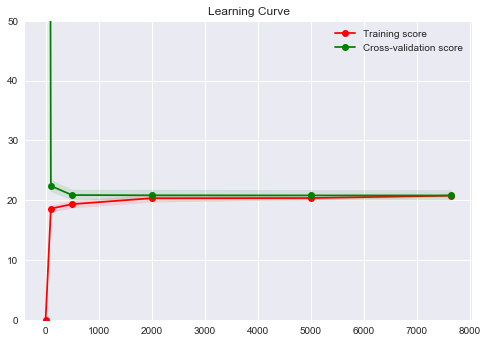

In [21]:
plot_learning_curve(train_sizes, train_scores, validation_scores)

#### From 500 training data points onward, the validation MSE stays roughly the same
Adding more training data points won’t lead to significantly better models. So instead of wasting time (and possibly money) with collecting more data, we need to try something else, like switching to an algorithm that can build more complex models

If the training error is very low, it means that the training data is fitted very well by the estimated model - **Low Bias**

If the training error is high, it means that the training data is not fitted well enough by the estimated model - **High Bias**




##### Taking the square root of 20 MW results in approximately 4.5 MW. Each target value represents net hourly electrical energy output. So for each hour our model is off by 4.5 MW on average  and  this would add up if we tried to predict the total energy output for one day or a longer period.
##### Because the validation MSE is high, and the training MSE is high as well, our model has a high bias problem

![image info](./images/low_high_bias.png)

![image info](./images/high_var.png)

----
#### Estimating variance can be done in at least two ways:
- By examining the gap between the validation learning curve and training learning curve
- By examining the training error: its value and its evolution as the training set sizes increase.

A narrow gap indicates low variance. Generally, the more narrow the gap, the lower the variance.
- If the variance is high, then the model fits training data too well. When training data is fitted too well, the model will have trouble generalizing on data that hasn’t seen in training

When such a model is tested on its training set, and then on a validation set, the training error will be low and the validation error will generally be high. As we change training set sizes, this pattern continues, and the differences between training and validation errors will determine that gap between the two learning curves.



- Our learning algorithm suffers from high bias and low variance, underfitting the training data.
- Adding more instances (rows) to the training data is hugely unlikely to lead to better models under the current learning algorithm.


In [22]:
from yellowbrick.model_selection import LearningCurve

In [23]:
train_sizes = [1,100, 1000, 2000,4000,6000]

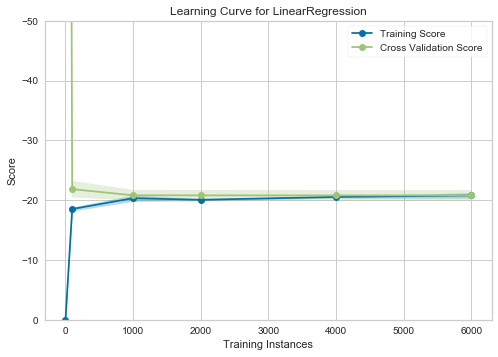

In [24]:
visualizer = LearningCurve(model, scoring='neg_mean_squared_error', train_sizes=train_sizes, n_jobs=4)
visualizer.fit(X_train,y_train)        # Fit the data to the visualizer
visualizer.ax.set_ylim(0,-50)
visualizer.show()           # Finalize and render the figure

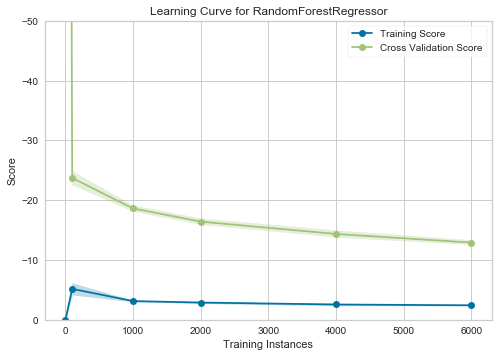

In [27]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()

visualizer = LearningCurve(rf_model, scoring='neg_mean_squared_error', train_sizes=train_sizes, n_jobs=4)
visualizer.fit(X_train,y_train)        # Fit the data to the visualizer
visualizer.ax.set_ylim(0,-50)
visualizer.show()           # Finalize and render the figure

- Looking at the validation curve, we can see that we’ve managed to decrease bias. There still is some significant bias, but not that much as before. Looking at the training curve, we can deduce that this time there’s a low bias problem.
- The new gap between the two learning curves suggests a substantial increase in variance. The low training MSEs corroborate this diagnosis of high variance. The large gap and the low training error also indicates an overfitting problem.

#### Overfitting happens when the model performs well on the training set, but far poorer on the test (or validation) set.

- Our learning algorithm (random forests) suffers from high variance and quite a low bias, overfitting the training data.
- Adding more training instances is very likely to lead to better models under the current learning algorithm.


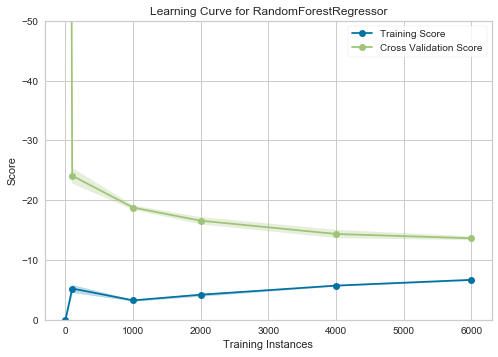

In [34]:
rf_model = RandomForestRegressor(max_leaf_nodes = 350)
visualizer = LearningCurve(rf_model, scoring='neg_mean_squared_error', train_sizes=train_sizes, n_jobs=4)
visualizer.fit(X_train,y_train)        # Fit the data to the visualizer
visualizer.ax.set_ylim(0,-50)
visualizer.show()           # Finalize and render the figure

True positive and true negatives are the observations that are correctly predicted and therefore shown in green. We want to minimize false positives and false negatives so they are shown in red color. These terms are a bit confusing. So let’s take each term one by one and understand it fully.

True Positives (TP) - These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes. E.g. if actual class value indicates that this passenger survived and predicted class tells you the same thing.

True Negatives (TN) - These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no. E.g. if actual class says this passenger did not survive and predicted class tells you the same thing.

False positives and false negatives, these values occur when your actual class contradicts with the predicted class.

False Positives (FP) – When actual class is no and predicted class is yes. E.g. if actual class says this passenger did not survive but predicted class tells you that this passenger will survive.

False Negatives (FN) – When actual class is yes but predicted class in no. E.g. if actual class value indicates that this passenger survived and predicted class tells you that passenger will die.

Once you understand these four parameters then we can calculate Accuracy, Precision, Recall and F1 score.

Accuracy - Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. One may think that, if we have high accuracy then our model is best. Yes, accuracy is a great measure but only when you have symmetric datasets where values of false positive and false negatives are almost same. Therefore, you have to look at other parameters to evaluate the performance of your model. For our model, we have got 0.803 which means our model is approx. 80% accurate.

Accuracy = TP+TN/TP+FP+FN+TN

Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answer is of all passengers that labeled as survived, how many actually survived? High precision relates to the low false positive rate. We have got 0.788 precision which is pretty good.

Precision = TP/TP+FP

Recall (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes. The question recall answers is: Of all the passengers that truly survived, how many did we label? We have got recall of 0.631 which is good for this model as it’s above 0.5.

Recall = TP/TP+FN

F1 score - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. In our case, F1 score is 0.701.

F1 Score = 2*(Recall * Precision) / (Recall + Precision)